## Assess some hotspots for FP bidirectionals (diverging and converging genes)
- False bidirectional calls are most likely going to be called where positive and negative strand genes are either starting near the same region and so their upstream expression might be called as a bidirectional if close enough. 
- Similarly, one gene's continued transcription might feed into that of another gene on the opposite strand. If a positive strand gene is on the left according to coordinates to a negative strand gene, genic bidirectionals of these genes is likely called due to normal "run-on" expression. (example: DDX11L17 & XR_007065318.1)

To address this, I will see how many of these diverging & converging regions exist:
- For diverging < 1kb
- For converging < 500bp
Then I will overlap these regions with the bidirectionals and see how many bidirectionals are called in the diverging regions or within the converging regions (including 1kb into the genes on both sides)

## 1. Identify the number of diverging & converging regions
1. Run bedtools closest by running the following code:
bedtools closest -S -k 2 -D -ref -a hg38_pos_refseq_prim_chrom_transcripts.bed -b hg38_refseq_prim_chrom_transcripts.bed > closest_pos_to_neg_prim_top2.bed
- -S indicates they must be on the opposite strands
- -k 2 indicates I want the two closest
- -D -ref indicates I want the -distance to indicate that the negative gene is upstream of the positive gene (more left coordinate wise)

2. Identify appropriate regions:
- First plot the Distances of all
- Converging regions of interest = +D < 500bp
- Diverging regions of interest = -D < 1kb

In [5]:
library(data.table)
library(ggplot2)
library(cowplot)

In [3]:
closest <- fread("../data/processed_annotations/closest_pos_to_neg_prim_top2.bed")
colnames(closest) <- c("chr1", "start1", "stop1", "TranscriptID1", "score1", "strand1", "GeneID1", "Length1", 
                       "chr2", "start2", "stop2", "TranscriptID2", "score2", "strand2", 
                       "Distance")
closest[1:2,]
dim(closest)

chr1,start1,stop1,TranscriptID1,score1,strand1,GeneID1,Length1,chr2,start2,stop2,TranscriptID2,score2,strand2,Distance
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>
chr1,11873,14409,DDX11L1:NR_046018.2,.,+,DDX11L1,2536,chr1,14361,29370,WASH7P:NR_024540.1,.,-,0
chr1,11873,14409,DDX11L1:NR_046018.2,.,+,DDX11L1,2536,chr1,17368,17436,MIR6859-1:NR_106918.1,.,-,2960


[1] 31749    15

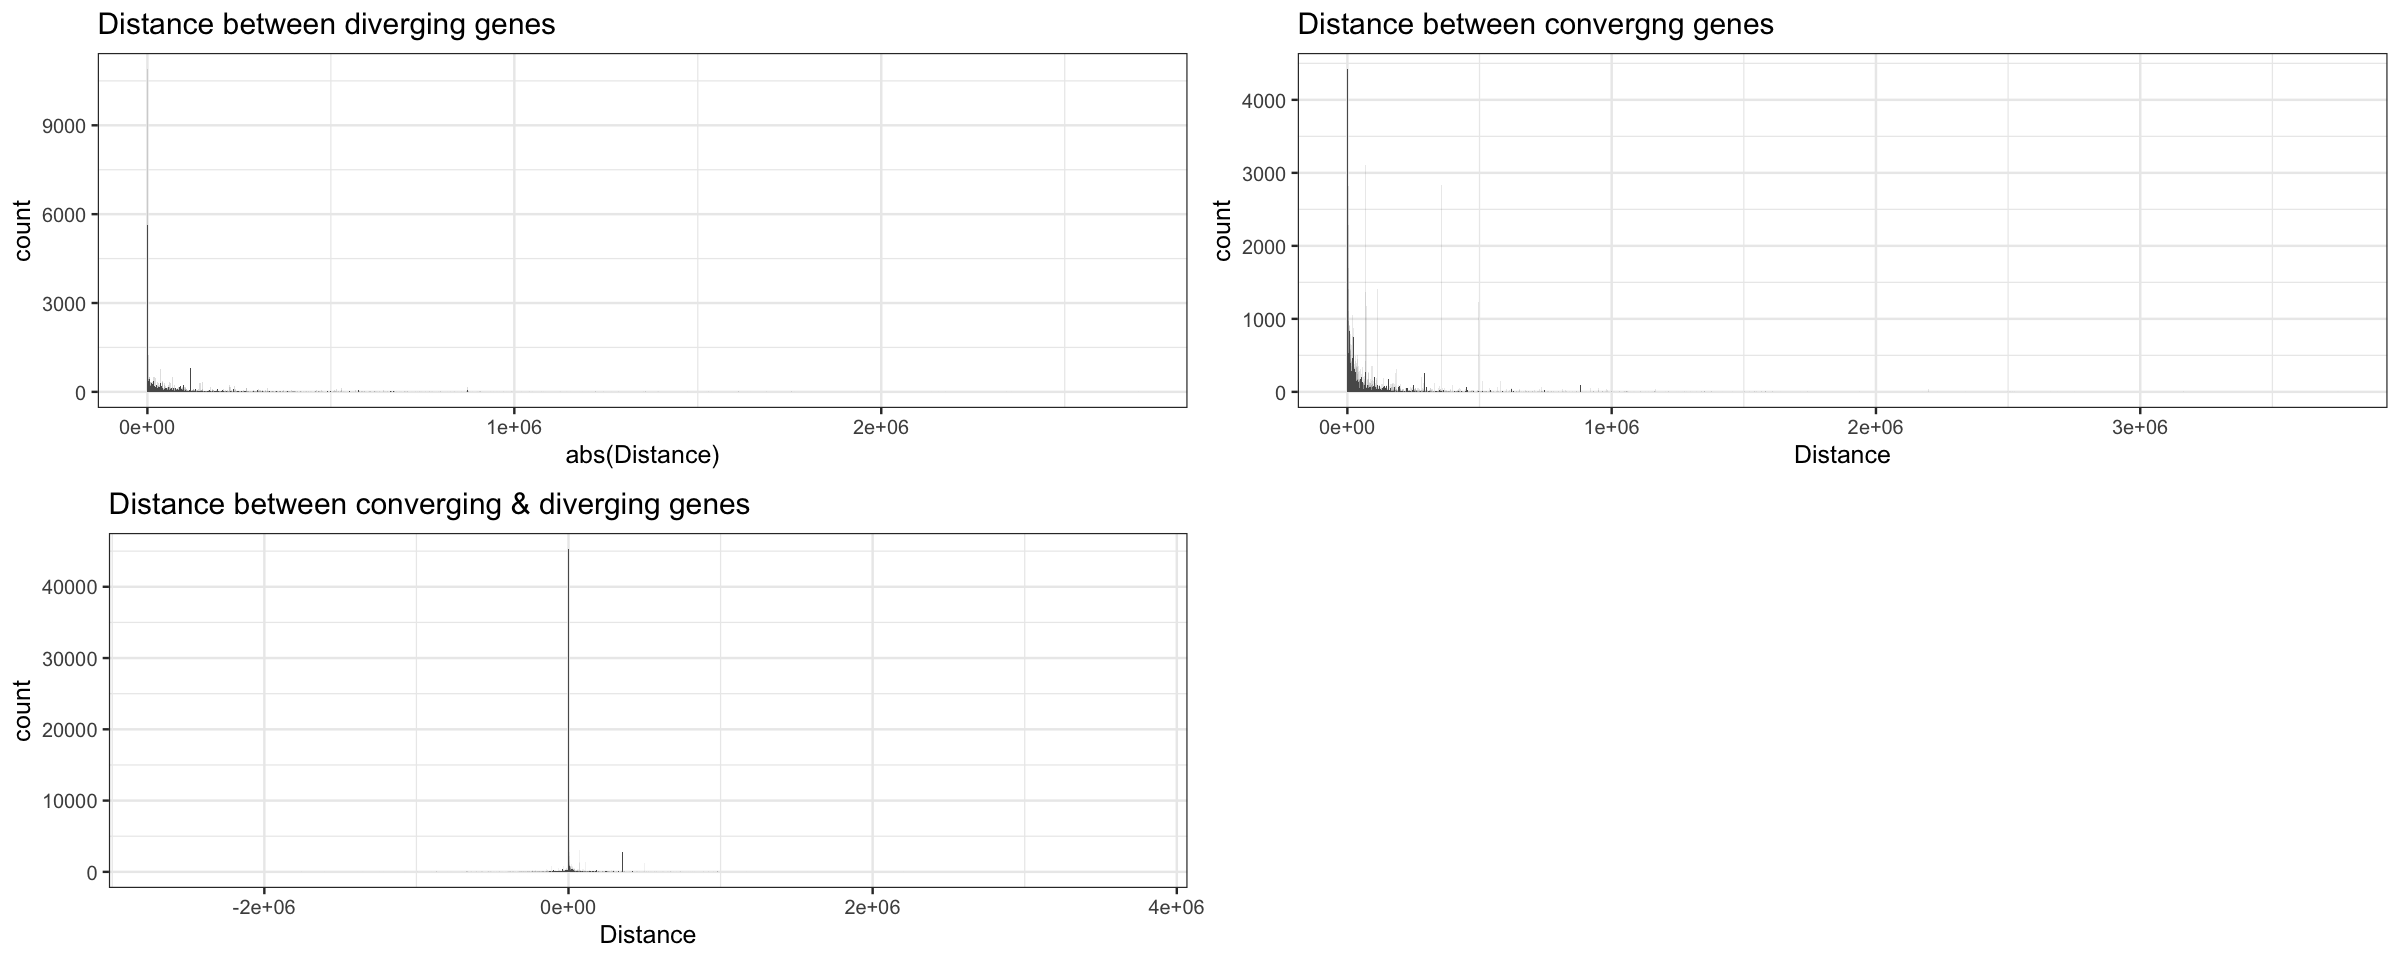

In [10]:
# graph the distances
options(repr.plot.height = 8, repr.plot.width = 20)
dim(closest[closest$Distance == 0,])
p1 <- ggplot(closest[closest$Distance < 0,], aes(x=abs(Distance))) + geom_histogram(binwidth=500) + 
ggtitle("Distance between diverging genes") + theme_bw(base_size=15)
p2 <- ggplot(closest[closest$Distance > 0,], aes(x=Distance)) + geom_histogram(binwidth=500) + 
ggtitle("Distance between convergng genes") + theme_bw(base_size=15)
p3 <- ggplot(closest, aes(x=Distance)) + geom_histogram(binwidth=500) + 
ggtitle("Distance between converging & diverging genes") + theme_bw(base_size=15)
plot_grid(p1, p2, p3, nrow=2)


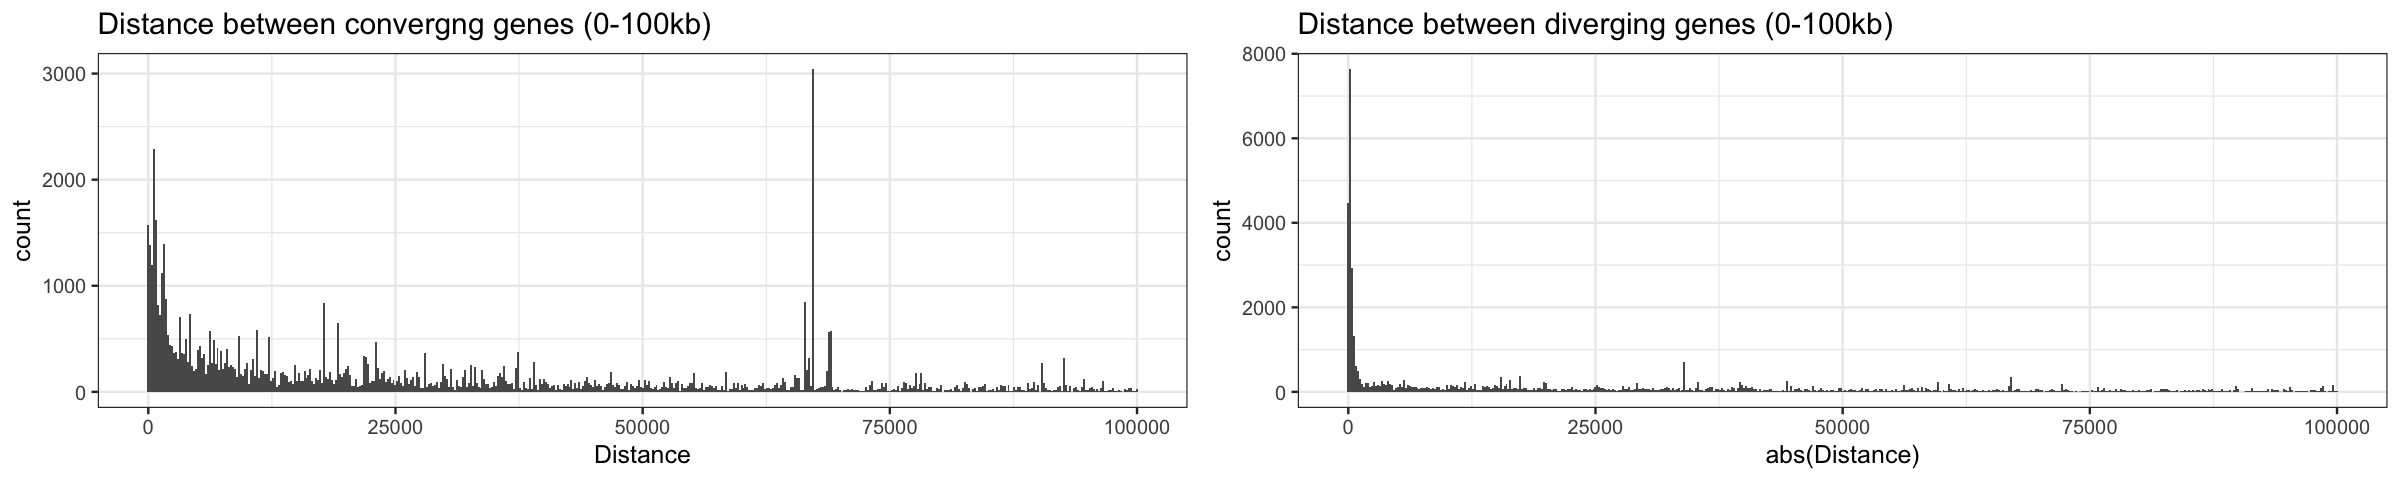

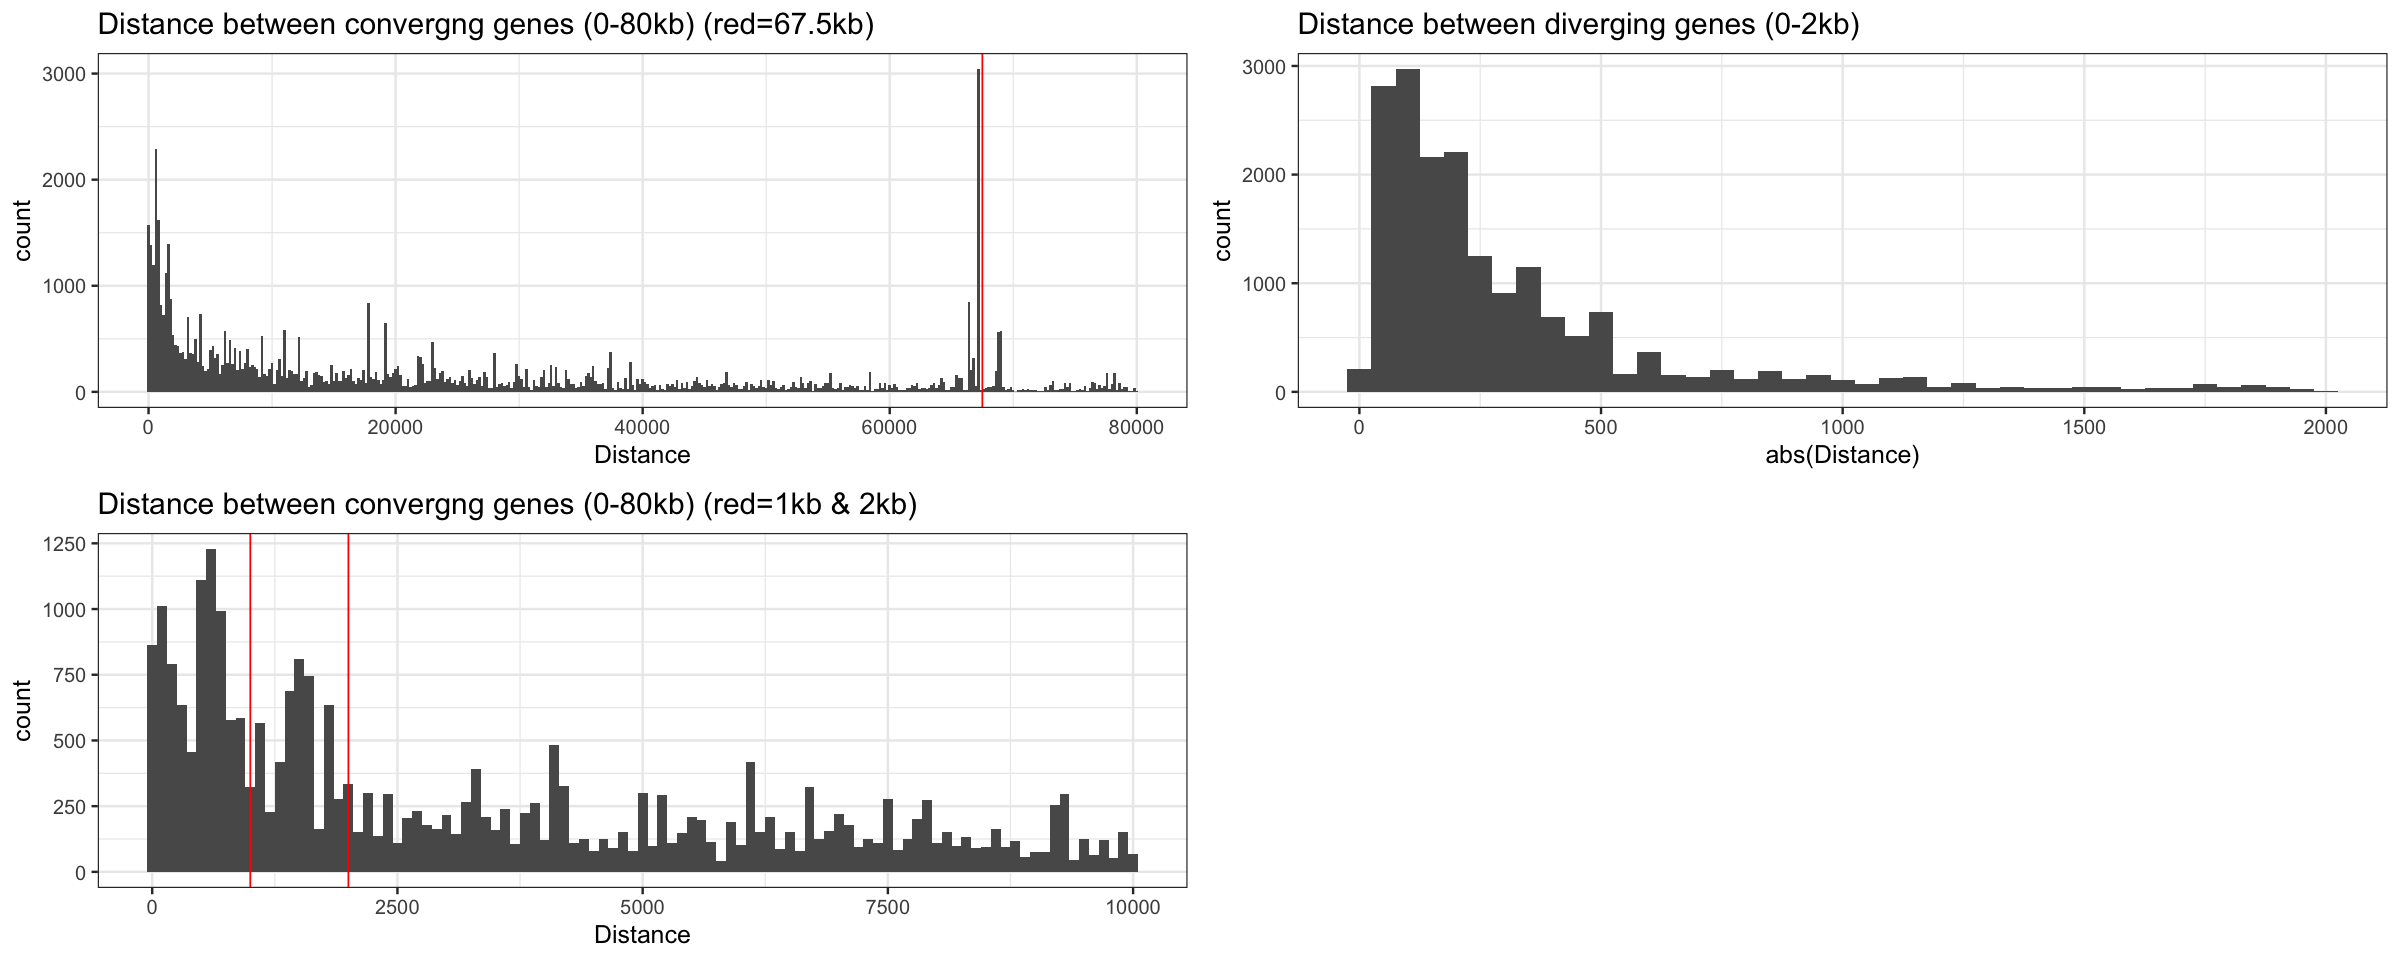

In [29]:
p1 <- ggplot(closest[closest$Distance < 0 & closest$Distance > -100000,], aes(x=abs(Distance))) + geom_histogram(binwidth=200) + 
ggtitle("Distance between diverging genes (0-100kb)") + theme_bw(base_size=15)
p2 <- ggplot(closest[closest$Distance > 0 & closest$Distance < 100000,], aes(x=Distance)) + geom_histogram(binwidth=200) + 
ggtitle("Distance between convergng genes (0-100kb)") + theme_bw(base_size=15)
options(repr.plot.height = 4, repr.plot.width = 20)
plot_grid(p2, p1, nrow=1)
p1 <- ggplot(closest[closest$Distance < 0 & closest$Distance > -2000,], aes(x=abs(Distance))) + geom_histogram(binwidth=50) + 
ggtitle("Distance between diverging genes (0-2kb)") + theme_bw(base_size=15)
p2 <- ggplot(closest[closest$Distance > 0 & closest$Distance < 80000,], aes(x=Distance)) + geom_histogram(binwidth=200) + 
ggtitle("Distance between convergng genes (0-80kb) (red=67.5kb)") + theme_bw(base_size=15) + 
geom_vline(xintercept=67500, color="red")
p3 <- ggplot(closest[closest$Distance > 0 & closest$Distance < 10000,], aes(x=Distance)) + geom_histogram(binwidth=100) + 
ggtitle("Distance between convergng genes (0-80kb) (red=1kb & 2kb)") + theme_bw(base_size=15) + 
geom_vline(xintercept=1000, color="red") + geom_vline(xintercept=2000, color="red")
options(repr.plot.height = 8, repr.plot.width = 20)
plot_grid(p2, p1, p3, nrow=2)

### Notes 
Based on the above, it seems that a good cutoff of diverging gene regions for possible bidirectionals is 500bp. 

The good cutoff for converging genes isn't as clear. There is a huge jump at 67.5k distance HOWEVER the likelihood of run on between there is less so. 

In [36]:
# Number of diverging regions <= 500bp
diverge <- closest[closest$Distance < 0 & closest$Distance >= -500,]
dim(diverge)
# Numbeer of converging regions w/ <=1kb
converge <- closest[closest$Distance > 0 & closest$Distance <= 1000,]
dim(converge)
# Number of regions of overlap
dim(closest[closest$Distance == 0,])

[1] 15040    15

[1] 8443   15

[1] 31749    15

## 2. Get the regions of interest to intersect called bidirectionals against

In [56]:
# Get diverging regions (right most of negative gene & left most of pos gene)
diverge[1:2,]
start <- diverge$stop2
end <- diverge$start1
distance <- end - start
name <- paste0(diverge$TranscriptID1, "||", diverge$TranscriptID2)
div_regions <- data.table("chr"=diverge$chr1, 
                          "start"=start, "stop"=end, "name"=name,
                          "distance"=distance)
div_regions[1:2,]
# check that none of the regions are above 500 or negative distance
dim(div_regions[div_regions$distance < 0 | div_regions$distance > 500,])

write.table(div_regions, 
            "../data/processed_annotations/diverging_hg38primgene_regions_500bpbelow_07-20-23.bed", 
           row.names=FALSE, col.names=FALSE, quote=FALSE, sep="\t")

chr1,start1,stop1,TranscriptID1,score1,strand1,GeneID1,Length1,chr2,start2,stop2,TranscriptID2,score2,strand2,Distance
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>
chr1,827590,859446,LINC01128:NR_047519.1,.,+,LINC01128,31856,chr1,826205,827522,LINC00115:NR_024321.1,.,-,-69
chr1,827590,843604,LINC01128:NR_047526.1,.,+,LINC01128,16014,chr1,826205,827522,LINC00115:NR_024321.1,.,-,-69


chr,start,stop,name,distance
<chr>,<int>,<int>,<chr>,<int>
chr1,827522,827590,LINC01128:NR_047519.1||LINC00115:NR_024321.1,68
chr1,827522,827590,LINC01128:NR_047526.1||LINC00115:NR_024321.1,68


[1] 0 5

In [77]:
# Get converging regions(right most of Pos gene & left most of neg gene)
converge[1:2,]
start <- converge$stop1
end <- converge$start2
distance <- end-start
name <- paste0(converge$TranscriptID1, "||", converge$TranscriptID2)
# check that the regions are all below 1kb and positive distance
length(distance)
length(distance[distance < 0])
length(distance[distance < 1000])

# now get the center of the distances and add 1kb both directions for region
center <- round((start + end)/2)
start[1:4]
end[1:4]
center[1:4]
start <- center - 1000
end <- center + 1000
conv_regions <- data.table("chr"=converge$chr1, 
                          "start"=start, "stop"=end, "name"=name,
                          "orig_distance"=distance, "new_distance"=end-start)
dim(conv_regions[conv_regions$new_distance !=2000,])
conv_regions[1:2,]
write.table(conv_regions, 
            "../data/processed_annotations/conv_hg38primgene_regions_1kbbelow_2kbwin_07-20-23.bed", 
           row.names=FALSE, col.names=FALSE, quote=FALSE, sep="\t")

start <- center - 2000
end <- center + 2000
conv_regions <- data.table("chr"=converge$chr1, 
                          "start"=start, "stop"=end, "name"=name,
                          "orig_distance"=distance, "new_distance"=end-start)
dim(conv_regions[conv_regions$new_distance !=2000,])
conv_regions[1:2,]
write.table(conv_regions, 
            "../data/processed_annotations/conv_hg38primgene_regions_1kbbelow_4kbwin_07-20-23.bed", 
           row.names=FALSE, col.names=FALSE, quote=FALSE, sep="\t")


chr1,start1,stop1,TranscriptID1,score1,strand1,GeneID1,Length1,chr2,start2,stop2,TranscriptID2,score2,strand2,Distance
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>
chr1,1280435,1292025,SCNN1D:NR_037668.3,.,+,SCNN1D,11590,chr1,1292390,1307930,ACAP3:NM_030649.3,.,-,366
chr1,1280435,1292025,SCNN1D:NM_001130413.4,.,+,SCNN1D,11590,chr1,1292390,1307930,ACAP3:NM_030649.3,.,-,366


[1] 8443

[1] 0

[1] 8443

[1] 1292025 1292025 1534685 1534685

[1] 1292390 1292390 1534777 1534777

[1] 1292208 1292208 1534731 1534731

[1] 0 6

chr,start,stop,name,orig_distance,new_distance
<chr>,<dbl>,<dbl>,<chr>,<int>,<dbl>
chr1,1291208,1293208,SCNN1D:NR_037668.3||ACAP3:NM_030649.3,365,2000
chr1,1291208,1293208,SCNN1D:NM_001130413.4||ACAP3:NM_030649.3,365,2000


[1] 8443    6

chr,start,stop,name,orig_distance,new_distance
<chr>,<dbl>,<dbl>,<chr>,<int>,<dbl>
chr1,1290208,1294208,SCNN1D:NR_037668.3||ACAP3:NM_030649.3,365,4000
chr1,1290208,1294208,SCNN1D:NM_001130413.4||ACAP3:NM_030649.3,365,4000


In [60]:
# check that no ids are shared between the two
length(intersect(div_regions$name, conv_regions$name))

[1] 0

### 3. See how many of the final filtered bidirectionals fall within these two types of regions
#### For converging regions, require 50% bid to be within region
bedtools intersect -f 0.5 -wo -a hg38_master_qc_gc_len_posneg_gene_filt_uniqueid.bed -b conv_hg38primgene_regions_1kbbelow_2kbwin_07-20-23.bed > overlaps_master_qc_gc_len_posneg_gene_filt_bid_conv.bed

bedtools intersect -f 0.5 -wo -a hg38_master_qc_gc_len_posneg_gene_filt_uniqueid.bed -b conv_hg38primgene_regions_1kbbelow_4kbwin_07-20-23.bed > overlaps_master_qc_gc_len_posneg_gene_filt_bid_conv4kb.bed
#### For diverging regions, require 25% region to be covered
bedtools intersect -F 0.25 -wo -a hg38_master_qc_gc_len_posneg_gene_filt_uniqueid.bed -b diverging_hg38primgene_regions_500bpbelow_07-20-23.bed > overlaps_master_qc_gc_len_posneg_gene_filt_bid_div.bed


In [89]:
# read in them
dim(conv_regions)
conv <- fread("../data/processed_annotations/overlaps_master_qc_gc_len_posneg_gene_filt_bid_conv.bed")
dim(conv)
colnames(conv) <- c("chr1", "Bid_Start", "Bid_Stop", "source", "BidID", 
                    "chr2", "Reg_Start", "Reg_Stop", "name", "orig_length", "new_length", "overlap")
length(unique(conv$BidID))
conv[1:2,]
conv4 <- fread("../data/processed_annotations/overlaps_master_qc_gc_len_posneg_gene_filt_bid_conv4kb.bed")
dim(conv4)
colnames(conv4) <- c("chr1", "Bid_Start", "Bid_Stop", "source", "BidID", 
                    "chr2", "Reg_Start", "Reg_Stop", "name", "orig_length", "new_length", "overlap")
length(unique(conv4$BidID))
conv4[1:2,]
div <- fread("../data/processed_annotations/overlaps_master_qc_gc_len_posneg_gene_filt_bid_div.bed")
dim(div_regions)
dim(div)
colnames(div) <- c("chr1", "Bid_Start", "Bid_Stop", "source", "BidID", 
                    "chr2", "Reg_Start", "Reg_Stop", "name", "length", "overlap")
length(unique(div$BidID))
div[1:2,]

[1] 8443    6

[1] 11254    12

[1] 868

chr1,Bid_Start,Bid_Stop,source,BidID,chr2,Reg_Start,Reg_Stop,name,orig_length,new_length,overlap
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>
chr1,1291883,1292359,dREG,chr1-1291883-1292359-dREG,chr1,1291208,1293208,SCNN1D:NR_037668.3||ACAP3:NM_030649.3,365,2000,476
chr1,1291883,1292359,dREG,chr1-1291883-1292359-dREG,chr1,1291208,1293208,SCNN1D:NM_001130413.4||ACAP3:NM_030649.3,365,2000,476


[1] 22959    12

[1] 1698

chr1,Bid_Start,Bid_Stop,source,BidID,chr2,Reg_Start,Reg_Stop,name,orig_length,new_length,overlap
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>
chr1,1291883,1292359,dREG,chr1-1291883-1292359-dREG,chr1,1290208,1294208,SCNN1D:NR_037668.3||ACAP3:NM_030649.3,365,4000,476
chr1,1291883,1292359,dREG,chr1-1291883-1292359-dREG,chr1,1290208,1294208,SCNN1D:NM_001130413.4||ACAP3:NM_030649.3,365,4000,476


[1] 15040     5

[1] 3073   11

[1] 398

chr1,Bid_Start,Bid_Stop,source,BidID,chr2,Reg_Start,Reg_Stop,name,length,overlap
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>
chr1,3857080,3857432,Tfit,chr1-3857080-3857432-Tfit,chr1,3857211,3857475,DFFB:NR_104222.2||CEP104:NM_014704.4,264,221
chr1,3857080,3857432,Tfit,chr1-3857080-3857432-Tfit,chr1,3857211,3857475,DFFB:NM_004402.4||CEP104:NM_014704.4,264,221


In [90]:
# read in TSS bidirectionals and see how many align witht he divergin
tss <- fread("../data/processed_annotations/tss_bids_08-14-23.txt")
length(intersect(div$BidID, tss$BidID))
length(unique(div$BidID))
length(tss$BidID)
setdiff(div$BidID, tss$BidID)

[1] 397

[1] 398

[1] 63033

[1] "chr22-29767086-29767274-Tfit"

## 4. Remove the 2kbwin converging & non-TSS diverging bidirectional for counting

In [91]:
# reead in the original bed file
orig_bed <- fread("../data/processed_annotations/hg38_master_qc_gc_len_posneg_gene_filt_uniqueid.bed")
orig_bed[1:2,]
dim(orig_bed)
orig <- nrow(orig_bed)
orig_bed <- orig_bed[!orig_bed$V5 %in% unique(conv$BidID),]
orig_bed <- orig_bed[orig_bed$V5 != setdiff(div$BidID, tss$BidID),]
dim(orig_bed)
orig-nrow(orig_bed)
length(unique(conv$BidID)) + 1

V1,V2,V3,V4,V5
<chr>,<int>,<int>,<chr>,<chr>
chr1,3917,4919,dREG,chr1-3917-4919-dREG
chr1,5632,6042,dREG,chr1-5632-6042-dREG


[1] 848490      5

[1] 847621      5

[1] 869

[1] 869

In [92]:
write.table(orig_bed, 
            "../data/processed_annotations/hg38_master_qc_gc_len_posneg_gene_filt_divconv_uniqueid.bed",
            quote=FALSE, sep="\t", row.names=FALSE, col.names=FALSE)

### 5. Merge the remaining bidirectionals if there is 1bp or greater overlap between them
```
bedtools sort -i hg38_master_qc_gc_len_posneg_gene_filt_divconv_uniqueid.bed > hg38_master_qc_gc_len_posneg_gene_filt_divconv_uniqueid_sorted.bed

bedtools merge -d -1 -c 5 -o distinct -i hg38_master_qc_gc_len_posneg_gene_filt_divconv_uniqueid_sorted.bed > hg38_master_qc_gc_len_posneg_gene_filt_divconv_uniqueid_merge.bed
```
